##Step 1: Import libraries and dataset

In [74]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns 
import matplotlib.pyplot as plt 

In [75]:
url = 'https://raw.githubusercontent.com/dsnqHuy/bitcoin_price_prediction/main/data/btc_365.csv'
df = pd.read_csv(url)

In [76]:
df.head()

,date,open,high,low,close
0,2021-10-30,62253.70,62359.25,60673.00,61859.19
1,2021-10-31,61859.19,62405.30,59945.36,61299.80
2,2021-11-01,61299.81,62437.74,59405.00,60911.11
3,2021-11-02,60911.12,64270.00,60624.68,63219.99
4,2021-11-03,63220.57,63500.00,60382.76,62896.48


In [77]:
df.dtypes

date      object
open     float64
high     float64
low      float64
close    float64
dtype: object

In [78]:
df['date'] = pd.to_datetime(df['date'])

##Step 2: Visualization

Text(0.5, 1.0, 'close histogram')

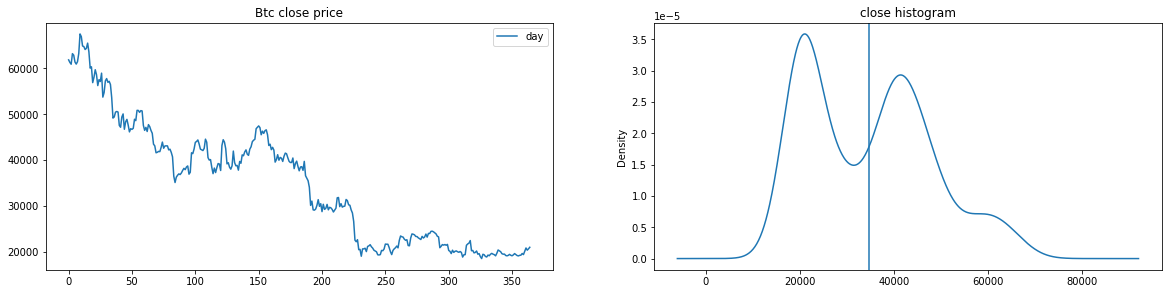

In [79]:
fig = plt.figure(figsize = (20, 10))

plt.subplot(221)
plt.plot(df['close'], '-', label = 'day')
plt.title('Btc close price')
plt.legend();

plt.subplot(222)
df['close'].plot(kind = 'kde')
plt.axvline(df['close'].mean())
plt.title('close histogram')

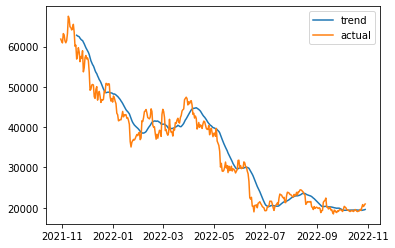

In [80]:
#See the trend of the data
plt.plot(df['date'], df['close'].rolling(20).mean(), label= 'trend')
plt.plot(df['date'], df['close'], label= 'actual')
plt.legend()

##Step 3: Normalizing

In [81]:
df_close = pd.DataFrame(df['close'])
df_close.shape

(365, 1)

In [82]:
df_close.head()

,close
0,61859.19
1,61299.80
2,60911.11
3,63219.99
4,62896.48


In [83]:
scaler = MinMaxScaler(feature_range = (0, 1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1, 1))
print(df_close.shape)

(365, 1)


In [84]:
train_size = int(df_close.shape[0] * 0.8)
test_size = int(df_close.shape[0] - train_size)
train_data, test_data = df_close[0:train_size, :], df_close[train_size:len(df_close),]
print(train_data.shape, test_data.shape)

(292, 1) (73, 1)


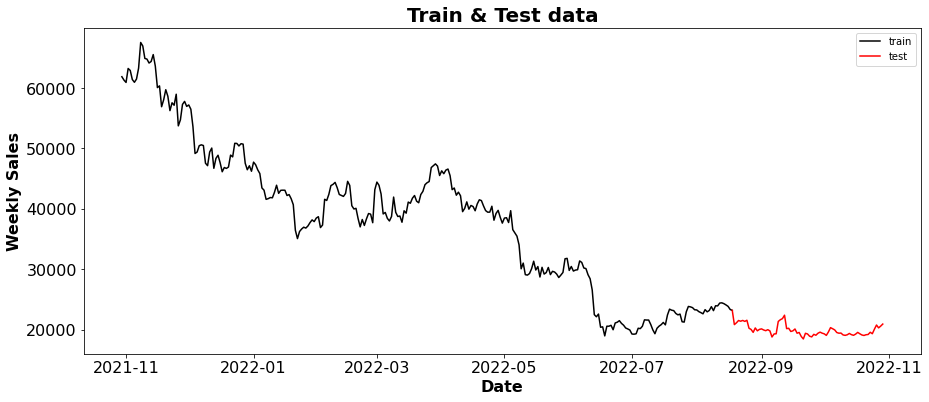

In [85]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = df['date'][:293], y = df['close'][:293], color = 'black')
sns.lineplot(x = df['date'][292:], y = df['close'][292:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [86]:
# convert an array of values into a dataset matrix for predicting purpose
def create_dataset(dataset, time_step, close):
    dataX, dataY = [], []
    if dataset.shape[0] > 200: #train_data
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]  
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
    else: #test_data
        for i in range(len(close)-time_step- 3 - len(dataset), len(close) - time_step - 1):
            a = close[i:(i+time_step), 0]  
            dataX.append(a)
            dataY.append(close[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [87]:
time_step = 14
X_train, y_train = create_dataset(train_data, time_step, df_close)
X_test, y_test = create_dataset(test_data, time_step, df_close)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)
print(X_train[0])

X_train:  (277, 14)
y_train:  (277,)
X_test:  (75, 14)
y_test (75,)
[0.88450624 0.87310512 0.86518309 0.91224118 0.90564761 0.87504563
 0.86571321 0.87658646 0.91333362 1.         0.98821612 0.94612395
 0.9439193  0.93063005]


##Step 4: Modeling and evaluation

In [88]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators= 1000)
xgb_model.fit(X_train, y_train, verbose=False)

[07:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [89]:
predictions = xgb_model.predict(X_test)
print("MAE : " + str(mean_absolute_error(y_test, predictions)))
print("RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

MAE : 0.017065943437432698
RMSE : 0.020817585595180554


In [90]:
train_predict=xgb_model.predict(X_train)
test_predict=xgb_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (277, 1)
Test data prediction: (75, 1)


In [91]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


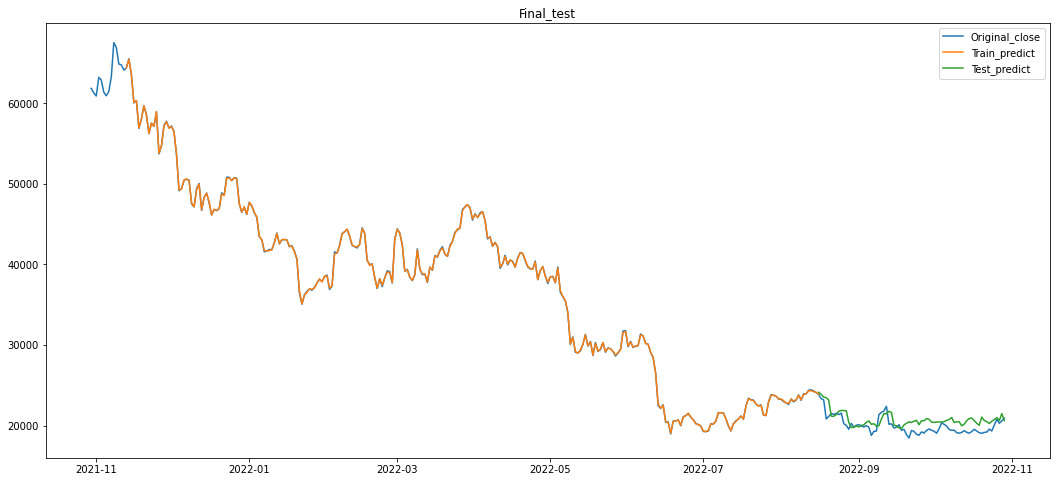

In [92]:
look_back=time_step
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back) - 1:len(df_close) , :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': df['date'],
                       'original_close': df['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
fig = plt.figure(figsize= (18, 8))
plt.plot(plotdf['date'], plotdf['original_close'], label = 'Original_close') 
plt.plot(plotdf['date'], plotdf['train_predicted_close'], label = 'Train_predict') 
plt.plot(plotdf['date'], plotdf['test_predicted_close'], label = 'Test_predict') 
plt.title("Final_test")
plt.legend();
plt.show()